In [1]:
!pip install transformers datasets
 # Importing necessary libraries with updated names
import pandas as pd
import torch as sentiment_torch
from sklearn.model_selection import train_test_split as sentiment_split
from transformers import BertTokenizer as SentimentBertTokenizer, BertForSequenceClassification as SentimentBertForSequenceClassification, Trainer as SentimentTrainer, TrainingArguments as SentimentTrainingArguments
from transformers import DataCollatorWithPadding as SentimentDataCollatorWithPadding
from datasets import Dataset as SentimentDataset
from sklearn.metrics import accuracy_score as sentiment_accuracy_score, f1_score as sentiment_f1_score, confusion_matrix as sentiment_confusion_matrix
import matplotlib.pyplot as sentiment_plt
import seaborn as sentiment_sns
import numpy as sentiment_np


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 require

In [6]:
from google.colab import drive
drive.mount('/content/drive')


# Load dataset
sentiment_df = pd.read_csv('/content/drive/My Drive/dataset.csv')

# Preprocess the data
# Renaming columns to be more descriptive
sentiment_df.columns = ['sentiment_text', 'sentiment_label']

# Splitting the dataset into training and testing sets
train_sentiment_df, test_sentiment_df = sentiment_split(sentiment_df, test_size=0.2, random_state=42)

# Converting DataFrame to HuggingFace Dataset format
train_sentiment_dataset = SentimentDataset.from_pandas(train_sentiment_df)
test_sentiment_dataset = SentimentDataset.from_pandas(test_sentiment_df)

# Loading the pre-trained BERT tokenizer for sentiment analysis
sentiment_tokenizer = SentimentBertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization function that also maps labels correctly
def tokenize_and_map_labels(examples):
    # Tokenize the text
    tokenized_inputs = sentiment_tokenizer(examples['sentiment_text'], truncation=True, padding=True)
    # Map the sentiment labels
    tokenized_inputs['labels'] = examples['sentiment_label']
    return tokenized_inputs

# Apply the tokenization and mapping function to the datasets
train_sentiment_dataset = train_sentiment_dataset.map(tokenize_and_map_labels, batched=True)
test_sentiment_dataset = test_sentiment_dataset.map(tokenize_and_map_labels, batched=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Map:   0%|          | 0/1838 [00:00<?, ? examples/s]

Map:   0%|          | 0/460 [00:00<?, ? examples/s]

In [8]:

# Data collator for padding sequences
sentiment_data_collator = SentimentDataCollatorWithPadding(tokenizer=sentiment_tokenizer)

# Loading pre-trained BERT model for sentiment classification
sentiment_model = SentimentBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Defining metrics for evaluation
compute_sentiment_metrics = lambda p: {
    'accuracy': sentiment_accuracy_score(p.label_ids, sentiment_np.argmax(p.predictions, axis=1)),
    'f1': sentiment_f1_score(p.label_ids, sentiment_np.argmax(p.predictions, axis=1), average='weighted')
}

# Defining training arguments for the sentiment analysis model
sentiment_training_args = SentimentTrainingArguments(
    output_dir='./sentiment_results',
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./sentiment_logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch"
)

# Initializing the Trainer for fine-tuning the sentiment model
sentiment_trainer = SentimentTrainer(
    model=sentiment_model,
    args=sentiment_training_args,
    train_dataset=train_sentiment_dataset,
    eval_dataset=test_sentiment_dataset,
    tokenizer=sentiment_tokenizer,
    data_collator=sentiment_data_collator,
    compute_metrics=compute_sentiment_metrics
)


# Training the sentiment analysis model
sentiment_trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.165700,0.039493,0.991304,0.991291
2,0.027300,0.033068,0.991304,0.991300
3,0.008100,0.007237,0.995652,0.995653


TrainOutput(global_step=690, training_loss=0.06702203128648841, metrics={'train_runtime': 98.6269, 'train_samples_per_second': 55.908, 'train_steps_per_second': 6.996, 'total_flos': 73591589594376.0, 'train_loss': 0.06702203128648841, 'epoch': 3.0})

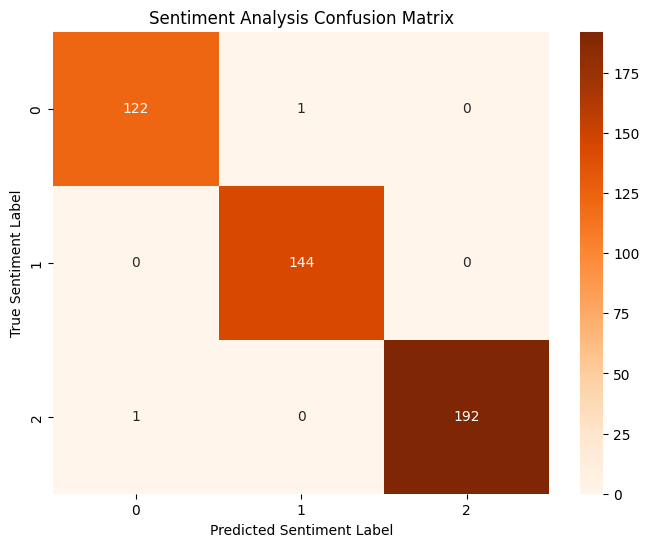

Text: I'm indifferent to his choice of clothing.
True Label: 1, Predicted Label: 1
---
Text: I'm feeling really positive about the progress we've made.
True Label: 2, Predicted Label: 2
---
Text: The presentation was captivating.
True Label: 2, Predicted Label: 2
---
Text: I'm disappointed with the lack of customer service at the store.
True Label: 0, Predicted Label: 0
---
Text: The weather is beautiful.
True Label: 2, Predicted Label: 2
---
Accuracy: 0.9956521739130435
F1 Score: 0.9956531117445815


In [9]:
# Evaluating the model's performance
sentiment_results = sentiment_trainer.evaluate()

# Generating predictions and a confusion matrix
sentiment_predictions = sentiment_trainer.predict(test_sentiment_dataset)
sentiment_y_true = sentiment_predictions.label_ids
sentiment_y_pred = sentiment_np.argmax(sentiment_predictions.predictions, axis=1)

sentiment_conf_matrix = sentiment_confusion_matrix(sentiment_y_true, sentiment_y_pred)

# Plotting the confusion matrix in orange color
sentiment_plt.figure(figsize=(8, 6))
sentiment_sns.heatmap(sentiment_conf_matrix, annot=True, fmt="d", cmap="Oranges")
sentiment_plt.title("Sentiment Analysis Confusion Matrix")
sentiment_plt.xlabel("Predicted Sentiment Label")
sentiment_plt.ylabel("True Sentiment Label")
sentiment_plt.show()

# Displaying sample results from the test set
for i in range(5):
    print(f"Text: {test_sentiment_df.iloc[i]['sentiment_text']}")
    print(f"True Label: {test_sentiment_df.iloc[i]['sentiment_label']}, Predicted Label: {sentiment_y_pred[i]}")
    print("---")

# Printing evaluation metrics
print("Accuracy:", sentiment_results['eval_accuracy'])
print("F1 Score:", sentiment_results['eval_f1'])
